In [1]:
%matplotlib nbagg

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import libertem.api as lt
import libertem.udf.base

from libertem.executor.inline import InlineJobExecutor

In [3]:
test_ctx = lt.Context(executor=InlineJobExecutor())

In [4]:
class DebugUDF(libertem.udf.base.UDF):
    def __init__(self, map_1, *args, **kwargs):
        super().__init__(map_1=map_1, *args, **kwargs)
        
    def get_result_buffers(self):
        return {
            'debug_1': self.buffer(
                kind="nav", dtype='int',
            ),
            'debug_2': self.buffer(
                kind="nav", dtype='int',
            ),
        }
    
    def preprocess(self):
        r = self.results
        p = self.params
        
        for i in range(len(r.debug_1)):
            r.debug_1[i] = p.map_1[i]
            
    def process_frame(self, frame):
        r = self.results
        p = self.params
        r.debug_2[:] = p.map_1

In [5]:
y, x = 113, 223

data = np.arange(y*x).reshape((y, x))

data *= data % 17

data[25:100, 80:120] *= 2

ds = test_ctx.load("memory", datashape=(y, x, 32, 32), sig_dims=2)

roi = np.zeros((y, x), dtype = "bool")
roi[13:73, 29:173] = True

udf = DebugUDF(
    map_1=DebugUDF.aux_data(
        kind="nav",
        data=data,
        dtype="int",
    )
)

res = test_ctx.run_udf(
    dataset=ds,
    udf=udf,
)

roi_res = test_ctx.run_udf(
    dataset=ds,
    udf=udf,
    roi=roi
)

debug_1_data = res['debug_1'].data
debug_2_data = res['debug_2'].data

roi_debug_1_data = np.zeros(ds.shape.nav)
roi_debug_2_data = np.zeros(ds.shape.nav)

roi_debug_1_data[roi] = roi_res['debug_1'].raw_data
roi_debug_2_data[roi] = roi_res['debug_2'].raw_data

<IPython.core.display.Javascript object>


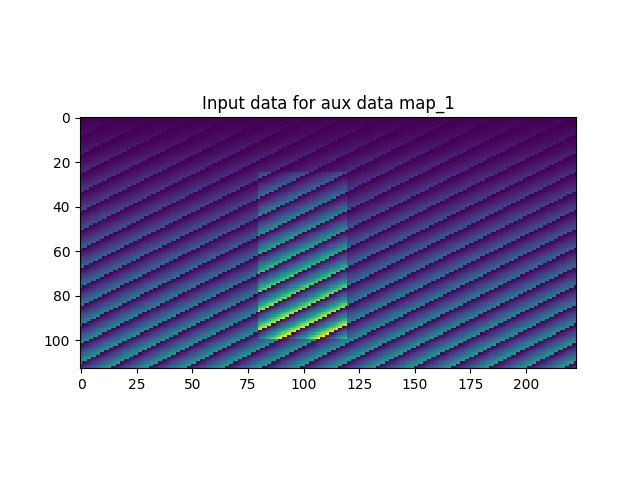

<IPython.core.display.Javascript object>


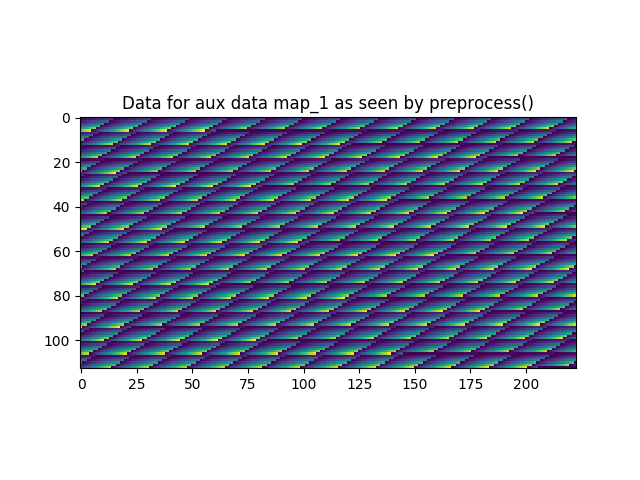

<IPython.core.display.Javascript object>


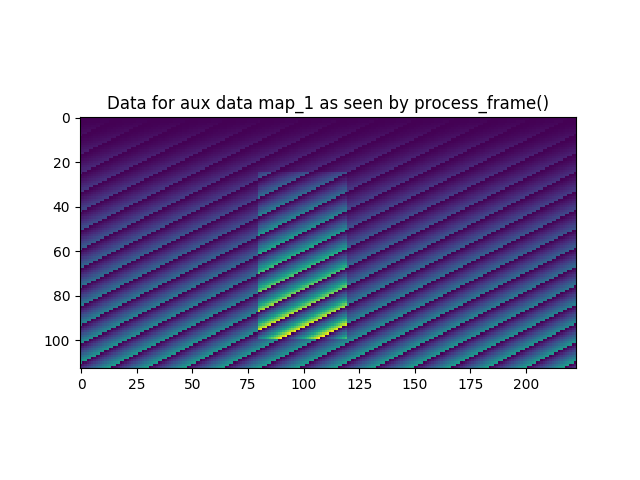

<IPython.core.display.Javascript object>


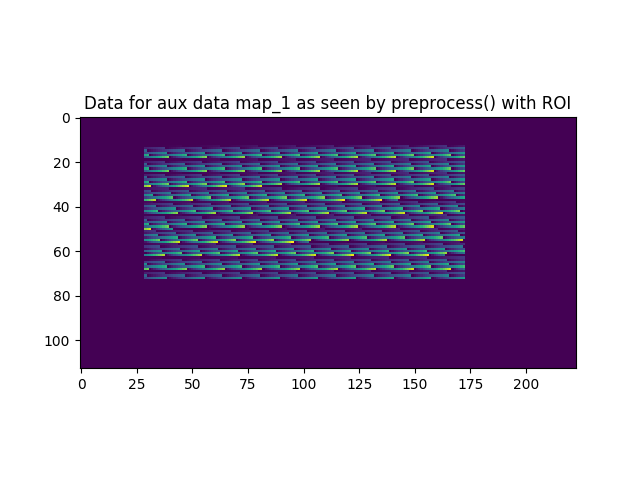

<IPython.core.display.Javascript object>


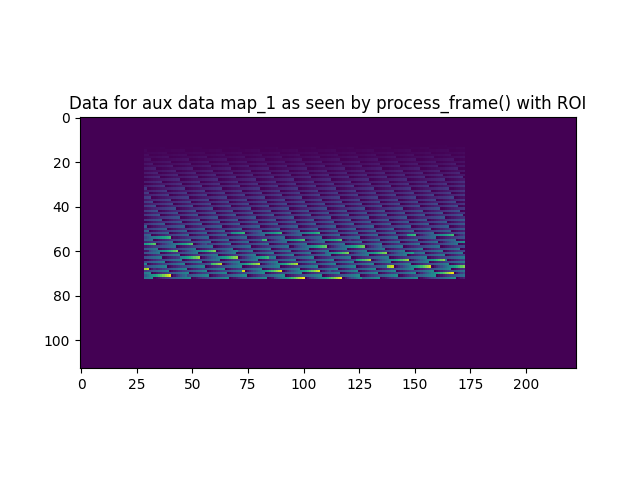

In [6]:
plt.subplots()
plt.title("Input data for aux data map_1")
plt.imshow(data)

plt.subplots()
plt.title("Data for aux data map_1 as seen by preprocess()")
plt.imshow(debug_1_data)

plt.subplots()
plt.title("Data for aux data map_1 as seen by process_frame()")
plt.imshow(debug_2_data)

plt.subplots()
plt.title("Data for aux data map_1 as seen by preprocess() with ROI")
plt.imshow(roi_debug_1_data)

plt.subplots()
plt.title("Data for aux data map_1 as seen by process_frame() with ROI")
plt.imshow(roi_debug_2_data)
